<a href="https://colab.research.google.com/github/UMB200/pytorch_projects/blob/main/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06.0 PyTorch Transfer Learning

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
#get helper functions from github
import os
import zipfile
from pathlib import Path
import sys

# Clone the repository
!git clone https://github.com/UMB200/pytorch_projects.git

# Create the new directory if it doesn't exist
if not os.path.exists('/content/going_modular'):
  !mkdir /content/going_modular

# Move all files from modular_helpers to the new directory
# Use a wildcard to select files, excluding directories if possible, though mv handles this gracefully
!mv /content/pytorch_projects/modular_helpers/* /content/going_modular/

# Remove the cloned repository
!rm -rf /content/pytorch_projects

# Add the path to the going_modular directory to sys.path so you can import from it
sys.path.insert(0, '/content/going_modular')

Cloning into 'pytorch_projects'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 171 (delta 4), reused 0 (delta 0), pack-reused 161 (from 1)
Receiving objects: 100% (171/171), 2.30 MiB | 33.62 MiB/s, done.
Resolving deltas: 100% (91/91), done.


## 1.0 Get data

In [3]:
import os
import zipfile
from pathlib import Path
import sys
from torch import nn

from going_modular import data_setup, engine, model_builder, utils

In [4]:
!python going_modular/get_data.py

Creating directory data_path/pizza_steak_sushi
Unzipping: data_path/pizza_steak_sushi.zip


In [5]:
!python going_modular/data_setup.py

In [6]:
# Define the train and test directory paths
train_dir = "data_path/pizza_steak_sushi/train"
test_dir = "data_path/pizza_steak_sushi/test"

#setup_dir_path(train_dir, test_dir)

## 2.0 Create DataSets and DataLoaders

### 2.1 Creating transform for `torchvision.models` Manually

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

You can use the following transform to normalize:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [7]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms =transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       normalize])

In [8]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79a830401350>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating transforms for torchviosn.models Automatically

In [9]:
weights_eff_net = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
weights_eff_net

EfficientNet_B0_Weights.IMAGENET1K_V1

In [10]:
# Get transforms used to create pretrained weights
auto_transforms = weights_eff_net.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [11]:
# Create  dataloaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79a830416210>,
 ['pizza', 'steak', 'sushi'])

## 3.0 Get a pretrained model
Sources
* PyTorch domain libraries
* Libraries like `timm` (torch image models)
* HuggingFace Hub
* Paperswithcode

### 3.1 Which model to choose
1. Take already well-performing model from similar space/problem pool
2. Speed - device mattters
3. Size (params)
4. Performance (acc)

https://docs.pytorch.org/vision/main/models.html#

For this case chosen one is:
https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights


### 3.2 Setup pretrained model


In [12]:
# Old method of creating pretarined model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(weights=None)
# Create a pretrained model torchvision v0.13+
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_eff_net = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
pretrained_model = torchvision.models.efficientnet_b0(weights=weights_eff_net).to(device)
pretrained_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
#189 Video 8/5/25
pretrained_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting summary of our model with `torchinfo.summary`

In [14]:
#190 video 8/6
#191 video 8/6
# Printvwith torchinfo
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
summary(pretrained_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Couldn't find torchinfo... installing it.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer

For parameters with requires_grad=False, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with requires_grad=False is "untrainable" or "frozen" in place.

In [15]:
# Video 192
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in pretrained_model.features.parameters():
  param.requires_grad = False

# Change the window size
pretrained_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [16]:
# Update the classifier head of our pretarined model to suite our problem
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
pretrained_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)).to(device)
pretrained_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

## 4.0 Train model

In [17]:
# Video 193 8/6/25
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_model.parameters(),
                             lr=0.001)

In [18]:
# import train function
from going_modular import engine
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

# Setup training and save the results
pretrained_model_results = engine.train(model=pretrained_model,
                                             train_dataloader=train_dataloader,
                                             test_dataloader=test_dataloader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             epochs=5,
                                             device=device)
end_timer = timer()
print(f"[INFO] Total training time: {end_timer-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 20.074 seconds


## 5.0 Evaluate model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


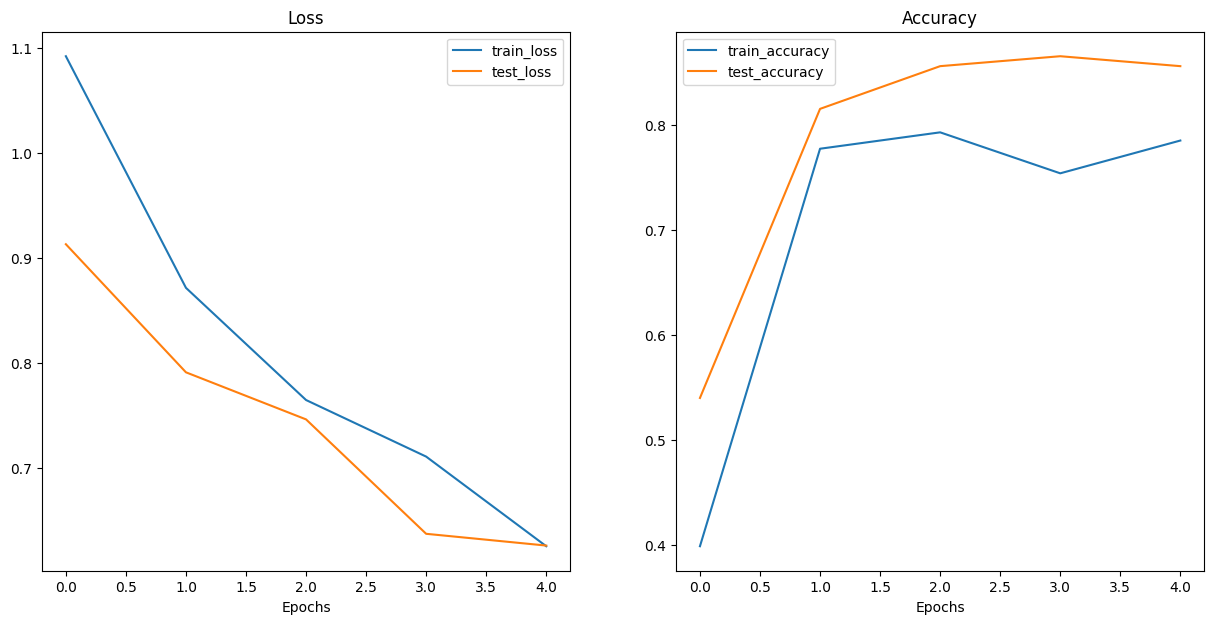

In [19]:
# 194 Video 8/6/25
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(pretrained_model_results)

## 6.0 Make predictions on images from the test set


In [20]:
# Video 196 8/7
import random
from PIL import Image
from typing import List, Tuple
from torchvision import transforms
import matplotlib.pyplot as plt


def predict_show_image_fn(model: torch.nn.Module,
                          image_path: str,
                          class_names: List[str],
                          image_size: Tuple[int, int] = (224, 224),
                          transform=None,
                          device: torch.device = device):
  """Makes a prediction on a target image and plots the image with its prediction."""

  # 1. load in image
  target_img = Image.open(image_path)

  # 3. Transform target image
  if transform is not None:
    img_transform = transform
  else:
    img_transform = transforms.Compose([
      transforms.Resize(image_size),
      transforms.ToTensor(),
      torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()
    ])

  # 4. Make sure model is on target device
  model.to(device)

  # 5. Turn on model evaluation and inference mode
  model.eval()
  with torch.inference_mode():
    #6. Transform and add an extra dimension to image
    target_img_transform = img_transform(target_img).unsqueeze(dim=0)

    # 7. Make a prediction on image
    target_img_pred = model(target_img_transform.to(device))

  # 8. Convert logits -> prediction probabilities using torch.softmax
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)

  # 9. Convert prediction probabilities -> prediction labels
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

  # 10. Plot the image alongside the predicion and prediction probability
  plt.figure()
  plt.title(f"Prediction: {class_names[target_img_pred_label]} | Probability: {target_img_pred_probs.max():.0%}")
  plt.imshow(target_img)
  plt.axis(False)

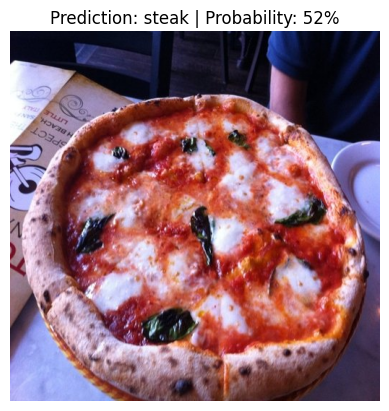

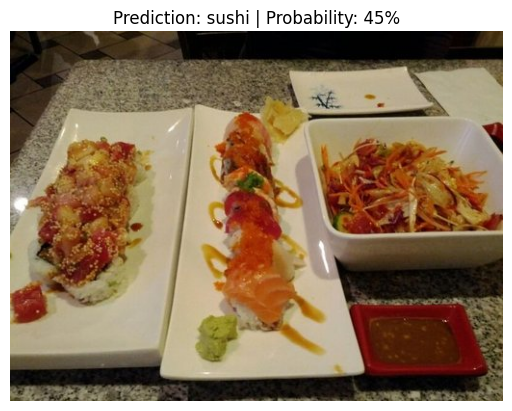

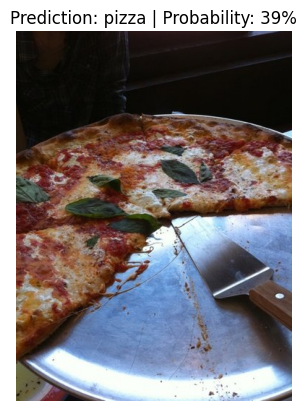

In [21]:
# Video 197 8/7/25
# Get random list of image paths
images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
random_image_paths = random.sample(test_image_path_list, k=images_to_plot)

# Make predictions
for image_path in random_image_paths:
  predict_show_image_fn(model=pretrained_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

### 6.1 Prediction on custom image

In [22]:
#Video 198 8/7/25
# Download custom image
import requests
custom_image_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"

custom_image_path = Path("data_path")/"04-pizza-dad.jpeg"

# Download image if it is not downloaded yet
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    req = requests.get(custom_image_url)
    print(f"Downloading image to {custom_image_path}")
    f.write(req.content)
else:
  print(f"{custom_image_path} already exists, moving on")

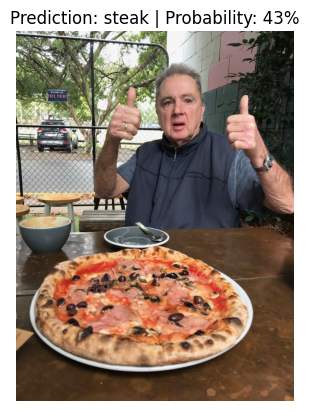

In [23]:
predict_show_image_fn(model=pretrained_model, image_path=custom_image_path, class_names=class_names)